<a href="https://colab.research.google.com/github/TeinkBR/1D_harmonic_oscillator/blob/main/Reduced_Basis_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Empirical Interpolation Method

Contributed by: 
- Jingyi Li(Teink)
- Edgard Bonilla
- Pablo Giuliani
- Kyle Godbey


### Overview

This section will walk through a simple implementation of the empirical interpolation method as applied to a sample problem. The layout is as follows:

* Numerically solve the eigenvalue problem to generate a training basis
* Use the reduced basis method to quickly generate solutions using the training points
* Use the empirical interpolation method to speed things up even more

In [ ]:
## This is for python code for reduced basis algorithm
# First load the numpy/scipy/matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
import pickle
#load interactive widgets
import ipywidgets as widgets
import scipy
from scipy import optimize
from scipy import interpolate
from math import exp,factorial                          #gaussian quadrature method                        
from scipy.special import hermite
from sympy import diff, integrate, exp          
from scipy.misc import derivative              # import from scipy derivative 
# Import hermite polynomials and factorial to use in normalization factor
from scipy.special import hermite
#If your screen has retina display this will increase resolution of plots
from mpmath import * 
## find root python
import pandas as pd
%config InlineBackend.figure_format = 'retina'

from numpy import linalg as LA

%matplotlib inline



Setting up some system parameters and global matrices we'll be needing elsewhere.

In [ ]:
####################################
## We are going to set the upper,lower limit, and step size of our guess function 
##
##
###################################
Xmin = -30;                                  ##  Lower limit range for the function 

Xmax = 30;                                   ##   Upper limit range for the function 

dx = 0.025;                                     ##  Step size for the finite element method

x = np.arange(Xmin, Xmax, dx)                 ## Initialize the abcissa

toep = np.zeros(x.shape)

toep[0] = -2
toep[1] = 1
print('toep=',toep)
lap = scipy.linalg.toeplitz(toep)/dx**2
print('lap',lap)


phi = np.zeros(x.shape)
lam=[]

toep= [-2.  1.  0. ...  0.  0.  0.]
lap [[-3200.  1600.     0. ...     0.     0.     0.]
 [ 1600. -3200.  1600. ...     0.     0.     0.]
 [    0.  1600. -3200. ...     0.     0.     0.]
 ...
 [    0.     0.     0. ... -3200.  1600.     0.]
 [    0.     0.     0. ...  1600. -3200.  1600.]
 [    0.     0.     0. ...     0.  1600. -3200.]]


Here we define our potential, $V(x)$, and the system of equations for the full numerical solution:

$-\nabla^2 \phi + V(x)\phi - \lambda\phi = 0$

$\langle\phi|\phi\rangle - 1 = 0$

In [ ]:
def V(A,Sig,X):
    return A*(-np.exp(-(X/Sig)**2)+1)

def true_sol(sol,x,Sig,A):
  residual = np.ones(x.shape[0]+1)
  
  residual[0:x.shape[0]] = np.dot(-lap,sol[0:x.shape[0]]) + V(A,Sig,x)*sol[0:x.shape[0]] - sol[-1]*sol[0:x.shape[0]]
  residual[-1] = np.dot(sol[0:x.shape[0]],sol[0:x.shape[0]]) - 1.0/dx  ### true wave function 

  return residual


First we solve the system numerically for one set of parameters to get the process down. We'll define a function to return solutions a little later to make it easier to generate our training points.

Eigenvalue =  1.3584835720727086


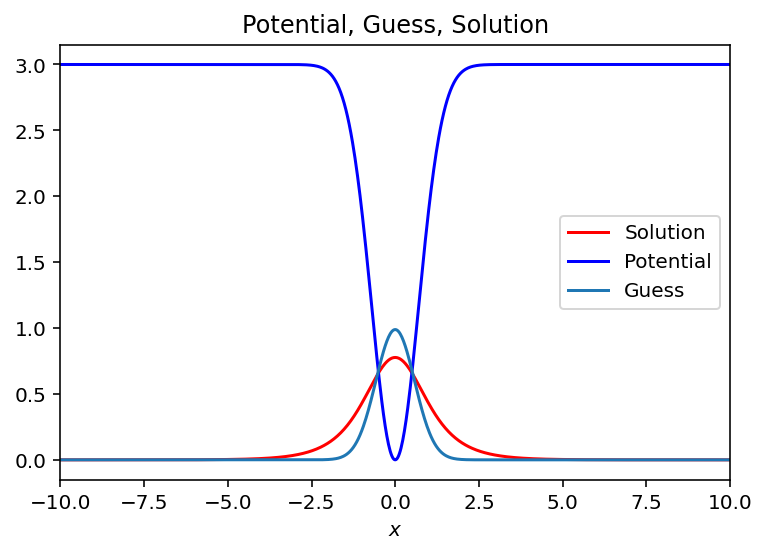

In [ ]:
##Example for finding the lowest energy solution:
##We utilize FindRoot to find the solution to the eigenvalue equation. We use an eigenfunction of the harmonic oscillator, or a constant function, as an initial guess to speed up calculations. FindRoot allows us to bypass finding all of the other eigenfunctions we don't care about by starting near the basin of attraction of the first eigenmode.

Sig0=1
A0=3

guess_phi = np.exp(-x**2/(2*(1/np.sqrt(A0/Sig0**2))**2))/np.sqrt(np.sqrt(np.pi)*(1/np.sqrt(A0/Sig0**2)))
guess_lam = 1.0

init_guess = np.zeros(x.shape[0]+1)
init_guess[0:x.shape[0]] = guess_phi
init_guess[-1] = guess_lam

# This takes a while on Colab
sol = scipy.optimize.root(true_sol,init_guess,args=(x,Sig0,A0))

phi = sol.x[0:x.shape[0]]  ## appending the root(residual?) to the first column of 
lam = sol.x[-1]             ## appending lato last row

print("Eigenvalue = ",lam)

plt.plot(x,phi,'r-',label="Solution")
plt.plot(x,V(A0,Sig0,x),'b',label="Potential")
plt.plot(x,guess_phi,'-',label="Guess")
plt.xlim([-10,10])
#plt.axis([0,6.6,0.0, 0.025])
plt.xlabel(r'$x$')
#plt.ylabel(r'Radial probability $r^2|R(r)|^2$')
plt.title(r'Potential, Guess, Solution')
plt.legend()
plt.show()

Here we define a helper function to generate a solution for a given set of parameters which will be used to generate the basis for the Galerkin projection. Right now I discard the lambda, but it can be used to precondition the lambdas for the reduced basis method in principle.

In [ ]:
from scipy.misc import derivative
#scipy.misc.derivative(func, x0, dx=1.0, n=1, args=(), order=3)
#derivative(f, 1.0, dx=1e-6)

#derivative(V(A,Sig,xx),xx,n=2,order=3)

In [ ]:
def true_phi(x,A,Sig):
  guess_phi = np.exp(-x**2/(2*(1/np.sqrt(A/Sig**2))**2))/np.sqrt(np.sqrt(np.pi)*(1/np.sqrt(A/Sig**2)))
  guess_lam = 1.0

  init_guess = np.zeros(x.shape[0]+1)
  init_guess[0:x.shape[0]] = guess_phi
  init_guess[-1] = guess_lam

  # This takes a while on Colab
  sol = scipy.optimize.root(true_sol,init_guess,args=(x,Sig,A))

  phi = sol.x[0:x.shape[0]]

  return phi

Now we select a few points in parameter space and generate the true solution, $\phi$, corresponding to those points. You can sample this however you like, but here we choose them by hand.

In [ ]:
## Full Galerkin

TrainingPoints = [(0.7, 1.5), (0.7, 8), (3.0, 1.5), (3, 8)]  ##

numTrain = len(TrainingPoints)  ## Number of training points

listPhi = []  ## List of the training functions 'phi'

listPsi = []  ## List of the training dual functions 'psi'

listCoeff = []

for alpha in TrainingPoints:
  listPhi.append(true_phi(x, alpha[0], alpha[1]))
  ### feeding listPhi and listPsi to the optimize 
 
##ListPlot(listPhi, Joined -> True, PlotRange -> All)
listPsi = listPhi

#plt.plot(x,listPhi,label="Phi plot")

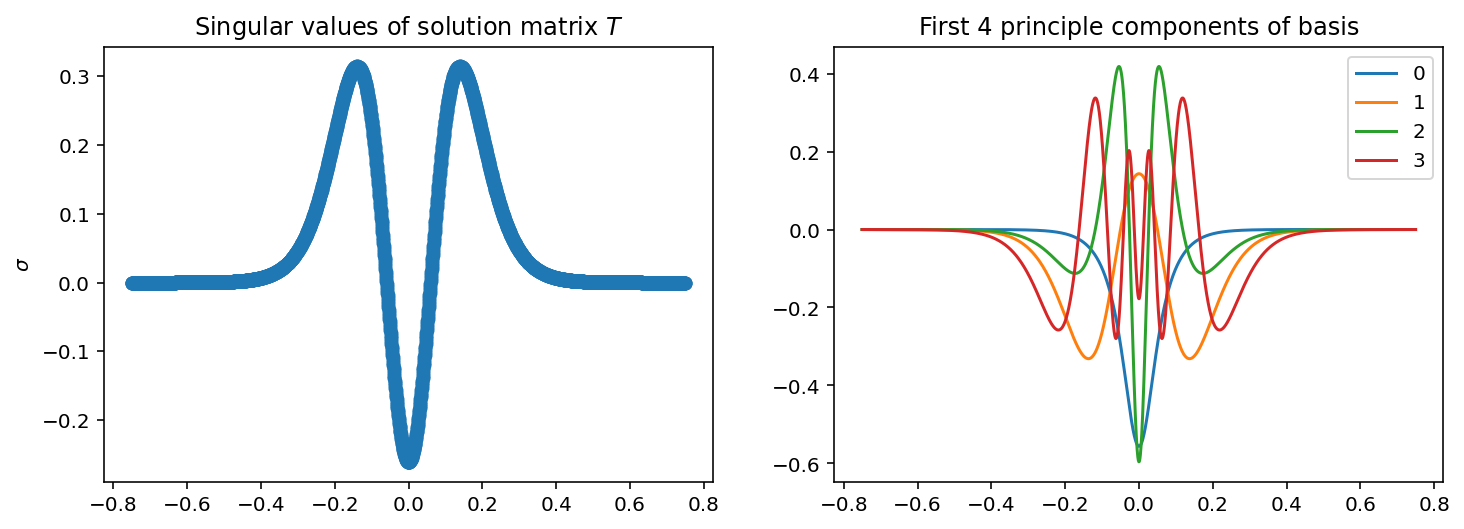

In [ ]:
def SVDCreator(Basis,NMax):
   u,sigma,v= np.linalg.svd(listPhi,full_matrices=True)
   v=v.T[0:NMax]*1/np.sqrt(dx)

   return v

#U, s, Vh = np.linalg.svd(listPhi)
n_comps = 4 # number of principle components to plot (i.e number of column vectors of SVD matrix V to plot)

POD = SVDCreator(listPhi, n_comps) 

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(x*dx,listPsi[1],'o-')
ax[0].set_title(r'Singular values of solution matrix $T$')
ax[0].set_ylabel(r'$\sigma$')
for i in np.arange(0,n_comps,1):
  
  ax[1].plot(x*dx,POD[i,:],label=str(i))

ax[1].set_title(f'First {n_comps} principle components of basis')
ax[1].legend()
plt.show()

In [ ]:
def SVDCreator(Basis,NMax):
   module=[u,v,x]
   u,sigma,v= np.linalg.svd(listPsi,full_matrices=True)
   v=v.T[1,NMax]*1/np.sqrt(dx)

   return v


SVDBasisPhi=SVDCreator(listPhi,4) 
listPhi[-SVDBasisPhi[[1]], SVDBasisPhi[[2]], 
  SVDBasisPhi[[3]], -SVDBasisPhi[[4]]]


plt.plot(x,listPhi,label="Phi plot")

testPhi=listPhi.T@listCoeff

RBphi = np.dot(listCoeff, listPhi)

def RBeigLHS(A, Sig):
  return np.dot(listPhi,(np.dot(-lap,RBphi)+V(A,Sig,x)*RBphi-RBlam*RBphi))

  

"""
SVDCreator[Basis_, NMax_] := Module[{},
  {u, \[Sigma], v} = SingularValueDecomposition[Basis, NMax];
  Transpose[v][[1 ;; NMax]]*1/Sqrt[dx]

SVDBasisPhi = SVDCreator[listPhi, 4]
listPhi = {-SVDBasisPhi[[1]], SVDBasisPhi[[2]], 
  SVDBasisPhi[[3]], -SVDBasisPhi[[4]]}

ListPlot[listPhi[[1 ;; 2]], Joined -> True, PlotRange -> All] 
testPhi = Dot[Transpose[listPhi], listCoeff];
RBphi = Dot[listCoeff, listPhi];

RBeigLHS[A_, Sig_] := 
  Dot[listPhi, (Dot[-lap, RBphi] + V[A, Sig, x]*RBphi - 
     RBlam*RBphi)];(*Eigenvalue equation*)
RBeigLHSLinearPart = 
  Expand[
   Dot[listPhi, (Dot[-lap, RBphi] - 
      RBlam*RBphi)]];(*Eigenvalue equation*)

RBeigLHSPotentialPart[A_, Sig_] := 
  Dot[listPhi, (V[A, Sig, x]*RBphi)];(*Eigenvalue equation*)      

RBeigLHSSeparated[A_, Sig_] :=RBeigLHSLinearPart + Expand[RBeigLHSPotentialPart[A, Sig]]

 """   





UnboundLocalError: ignored